In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

In [2]:
df = pd.read_csv("../data/processed/market_data_processed.csv")
df.head()

,Date,SP500_Close,VIX_Close,SP500_LogReturn
0,2010-01-05,1136.520020,19.350000,0.003111
1,2010-01-06,1137.140015,19.160000,0.000545
2,2010-01-07,1141.689941,19.059999,0.003993
3,2010-01-08,1144.979980,18.129999,0.002878
4,2010-01-11,1146.979980,17.549999,0.001745


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4058 entries, 0 to 4057
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4058 non-null   str    
 1   SP500_Close      4058 non-null   float64
 2   VIX_Close        4058 non-null   float64
 3   SP500_LogReturn  4058 non-null   float64
dtypes: float64(3), str(1)
memory usage: 126.9 KB


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4058 entries, 0 to 4057
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             4058 non-null   datetime64[us]
 1   SP500_Close      4058 non-null   float64       
 2   VIX_Close        4058 non-null   float64       
 3   SP500_LogReturn  4058 non-null   float64       
dtypes: datetime64[us](1), float64(3)
memory usage: 126.9 KB


In [5]:
returns = df["SP500_LogReturn"] * 100 


In [6]:
returns = returns.dropna()
returns.head()

0    0.311083
1    0.054537
2    0.399322
3    0.287758
4    0.174523
Name: SP500_LogReturn, dtype: float64

# Fit GARCH(1,1)

In [7]:
model = arch_model(
    returns,
    vol="Garch",
    p=1,
    q=1,
    dist="normal"
)

garch_result = model.fit(disp="off")

In [8]:
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:        SP500_LogReturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5226.97
Distribution:                  Normal   AIC:                           10461.9
Method:            Maximum Likelihood   BIC:                           10487.2
                                        No. Observations:                 4058
Date:                Fri, Feb 27 2026   Df Residuals:                     4057
Time:                        14:18:00   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0777  1.191e-02      6.522  6.956e-11 [5.435e-0

# Parameter Interpretation 

In [9]:
params = garch_result.params
alpha_beta_sum = params["alpha[1]"] + params["beta[1]"]
alpha_beta_sum

np.float64(0.9665308230283414)

In [10]:
# Volatility shocks decay slowly.

In [11]:
df.loc[returns.index, "GARCH_Vol"] = garch_result.conditional_volatility / 100

In [12]:
returns

0       0.311083
1       0.054537
2       0.399322
3       0.287758
4       0.174523
          ...   
4053    0.103079
4054    0.555064
4055   -0.282612
4056    0.691576
4057   -1.043996
Name: SP500_LogReturn, Length: 4058, dtype: float64

In [ ]:
df["HV_20_Annualized"] = returns.rolling(20).std() * np.sqrt(252)

In [17]:
df

,Date,SP500_Close,VIX_Close,SP500_LogReturn,GARCH_Vol,HV_20_Annualized
0,2010-01-05,1136.520020,19.350000,0.003111,0.009725,NaN
1,2010-01-06,1137.140015,19.160000,0.000545,0.008999,NaN
2,2010-01-07,1141.689941,19.059999,0.003993,0.008316,NaN
3,2010-01-08,1144.979980,18.129999,0.002878,0.007827,NaN
4,2010-01-11,1146.979980,17.549999,0.001745,0.007345,NaN
...,...,...,...,...,...,...
4053,2026-02-17,6843.220215,20.290001,0.001031,0.009578,14.525628
4054,2026-02-18,6881.310059,19.620001,0.005551,0.008823,12.560290
4055,2026-02-19,6861.890137,20.230000,-0.002826,0.008382,11.924759
4056,2026-02-20,6909.509766,19.090000,0.006916,0.007911,12.024795


In [18]:
df["HV_20_Annualized"].isnull().sum()

np.int64(19)

In [21]:
df.dropna(inplace=True)

In [22]:
df["HV_20_Annualized"].isnull().sum()

np.int64(0)

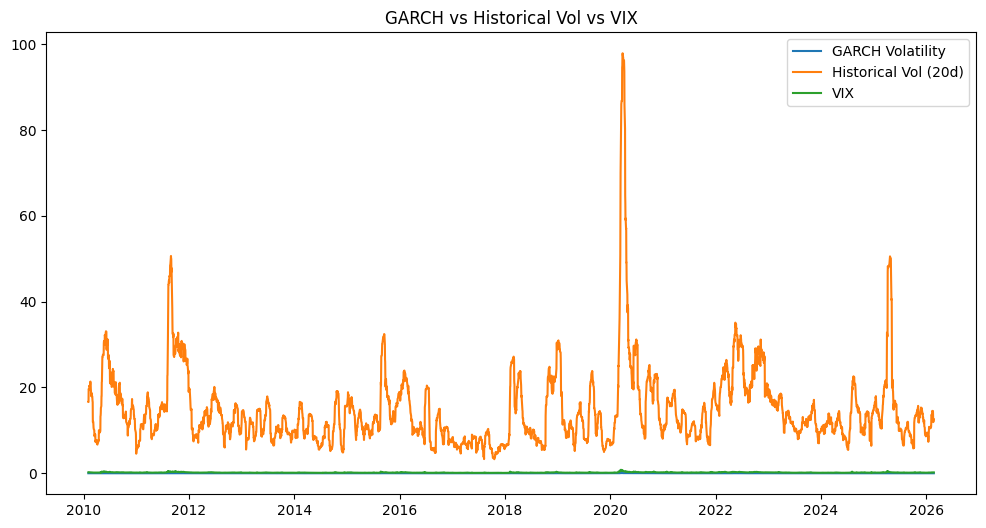

In [23]:
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["GARCH_Vol"], label="GARCH Volatility")
plt.plot(df["Date"], df["HV_20_Annualized"], label="Historical Vol (20d)")
plt.plot(df["Date"], df["VIX_Close"]/100, label="VIX")

plt.legend()
plt.title("GARCH vs Historical Vol vs VIX")
plt.show()